# Intro
In this notebook I am going to explore the data a little bit.
The competition goal is to give probability estimation to if an image contains a cat or a dog.
The content score is measured by by LogLoss, where
* y=1 -> dog
* y=0 -> cat

We will try to minimize the score
      

# Preprocess the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tqdm import tqdm      # a nice pretty percentage bar for tasks.

 Creating lists of image file names for both cats and dogs

In [2]:
TRAIN_DIR = '../input/train/' 
TEST_DIR = '../input/test/'

image_list = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] 
dog_image_list = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
cat_image_list = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]
test_image_list = [TEST_DIR+i for i in os.listdir(TEST_DIR)]


In [3]:
print('Total images:\t',len(image_list),
      '\nDog Images:\t',len(dog_image_list),
      '\nCat Images:\t',len(cat_image_list),
      '\nTestImages:\t',len(test_image_list))

Total images:	 25000 
Dog Images:	 12500 
Cat Images:	 12500 
TestImages:	 12500


We can see that there is equal number of images to cats and dogs

Now we are going to load the images and resize them to 64x64x3

In [4]:
ROWS = 128
COLS = 128
CHANNELS = 3

def load_image(file_path, size=(ROWS,COLS)):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    b,g,r = cv2.split(img)
    rgb_img = cv2.merge([r,g,b])
    return cv2.resize(rgb_img, (ROWS,COLS))
    

def load_image_list(file_list, ret_labels=True):
    count = len(file_list)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
    labels = []
    
    for i, image_name in tqdm(enumerate(file_list)):
        data[i] = load_image(image_name)
        if ret_labels:
            if 'dog' in image_name:
                labels.append(1)
            else:
                labels.append(0)
    return data, labels

def matrix_divide_by_chunks(matrix, chunk_size):
    for i in range(chunk_size):
        matrix[(chunk_size*i):(chunk_size*(i+1))] / 255.0
#     org_flat_mat = matrix.flatten()
#     final_matrix = np.zeros(shape=org_flat_mat.shape)
    
#     for i in range(chunk_size):
#         final_matrix = org_flat_mat[i*chunk_size:(i+1)*chunk_size] / 255.0
    
#     return final_matrix.reshape(matrix.shape)
        
    

In [5]:
# dog_image_list = dog_image_list[:1000]
# cat_image_list = cat_image_list[:1000]

print("Loading Dogs' Images...")
dog_data_images, dog_data_labels = load_image_list(dog_image_list)
dog_train_images, dog_val_images, dog_train_labels, dog_val_labels = train_test_split(dog_data_images, dog_data_labels,
                                                    test_size=0.2, random_state=2)


print("Loading Cats' Images...")
cat_data_images, cat_data_labels = load_image_list(cat_image_list)
cat_train_images, cat_val_images, cat_train_labels, cat_val_labels = train_test_split(cat_data_images, cat_data_labels,
                                                   test_size=0.2, random_state=2)

train_data = np.concatenate((dog_train_images, cat_train_images), axis=0)
train_labels = dog_train_labels + cat_train_labels
# train_labels = to_categorical(train_labels, num_classes=2)

val_data = np.concatenate((dog_val_images, cat_val_images), axis=0)
val_labels = dog_val_labels + cat_val_labels
# val_labels = to_categorical(val_labels, num_classes=2)

Loading Dogs' Images...


12500it [00:42, 292.99it/s]


Loading Cats' Images...


12500it [00:40, 308.15it/s]


In [6]:
# Normalize the data
matrix_divide_by_chunks(train_data, 1000)
matrix_divide_by_chunks(val_data, 1000)
# train_data = train_data / 255.0
# val_data = val_data /255.0

print ("Training data shape: {}".format(train_data.shape))
print ("Labels length: {}".format(len(train_labels)))

Training data shape: (20000, 128, 128, 3)
Labels length: 20000


## Lets show some images
sum dogs images

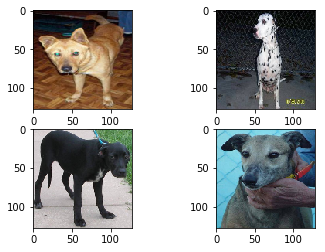

In [7]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(train_data[0])
axarr[0,1].imshow(train_data[1])
axarr[1,0].imshow(train_data[2])
axarr[1,1].imshow(train_data[3])

Some cats Images

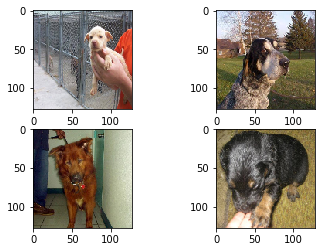

In [8]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(train_data[1000])
axarr[0,1].imshow(train_data[1001])
axarr[1,0].imshow(train_data[1002])
axarr[1,1].imshow(train_data[1003])
plt.show()

We can see that some images are not face closeup of the animal, but a whole body shots.

We also go some strange images like dog.10801 (Finger in a metal loop???)


In [9]:
# strange_dog = load_image(TRAIN_DIR+'dog.10801.jpg', size=(350,261))
# plt.imshow(strange_dog)

# Building simple classifier

We are going to build a deep network for this task using keras and tensorflow.

In [10]:
regl2 = regularizers.l2(0.01)

model = Sequential()

# BLOC 1
model.add(Conv2D(filters=64, kernel_size=(4,4), padding='Same', activation='relu', input_shape=(ROWS,COLS,CHANNELS)))
model.add(Conv2D(filters=64, kernel_size=(4,4), padding='Same', activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Conv2D(filters=64, kernel_size=(4,4), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.5))

# BLOC 2
model.add(Conv2D(filters=32, kernel_size=(4,4), padding='Same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(4,4), padding='Same', activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Conv2D(filters=32, kernel_size=(4,4), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.5))

# BLOC 3
model.add(Conv2D(filters=64, kernel_size=(4,4), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(4,4), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.5))

# BLOC 4
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=regl2))
model.add(Dense(1024, activation='relu', kernel_regularizer=regl2))
# model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid')) # check if we could use softmax function instead

optimizer = SGD(lr=0.01)


model.compile(optimizer=optimizer, loss="binary_crossentropy",
              metrics=["accuracy"])

In [11]:
# Save the checkpoint in the /output folder
filepath = "cat_dog_best_reg2_v2"

# Keep only a single checkpoint, the best over test accuracy.
checkpoint = ModelCheckpoint(filepath,
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min')

epochs = 75

batch_size = 50

history = model.fit(x=train_data, y=train_labels, batch_size=batch_size,
                    epochs=epochs, verbose=2, validation_data=(val_data, val_labels),
                   callbacks=[checkpoint])

Train on 20000 samples, validate on 5000 samples
Epoch 1/75
 - 171s - loss: 35.3190 - acc: 0.4998 - val_loss: 33.1878 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 33.18783, saving model to cat_dog_best_reg2_v2
Epoch 2/75
 - 162s - loss: 31.2784 - acc: 0.5000 - val_loss: 29.4591 - val_acc: 0.5000

Epoch 00002: val_loss improved from 33.18783 to 29.45905, saving model to cat_dog_best_reg2_v2
Epoch 3/75
 - 161s - loss: 27.8320 - acc: 0.5000 - val_loss: 26.2816 - val_acc: 0.5000

Epoch 00003: val_loss improved from 29.45905 to 26.28165, saving model to cat_dog_best_reg2_v2
Epoch 4/75
 - 160s - loss: 24.8952 - acc: 0.5000 - val_loss: 23.5741 - val_acc: 0.5000

Epoch 00004: val_loss improved from 26.28165 to 23.57408, saving model to cat_dog_best_reg2_v2
Epoch 5/75
 - 160s - loss: 22.3926 - acc: 0.5000 - val_loss: 21.2669 - val_acc: 0.5000

Epoch 00005: val_loss improved from 23.57408 to 21.26689, saving model to cat_dog_best_reg2_v2
Epoch 6/75
 - 160s - loss: 20.2601 - acc:

Epoch 48/75
 - 160s - loss: 8.0171 - acc: 0.5000 - val_loss: 8.0136 - val_acc: 0.5000

Epoch 00048: val_loss did not improve from 6.56959
Epoch 49/75
 - 160s - loss: 8.0104 - acc: 0.5000 - val_loss: 8.0073 - val_acc: 0.5000

Epoch 00049: val_loss did not improve from 6.56959
Epoch 50/75
 - 160s - loss: 8.0046 - acc: 0.5000 - val_loss: 8.0020 - val_acc: 0.5000

Epoch 00050: val_loss did not improve from 6.56959
Epoch 51/75
 - 160s - loss: 7.9996 - acc: 0.5000 - val_loss: 7.9974 - val_acc: 0.5000

Epoch 00051: val_loss did not improve from 6.56959
Epoch 52/75
 - 160s - loss: 7.9954 - acc: 0.5000 - val_loss: 7.9935 - val_acc: 0.5000

Epoch 00052: val_loss did not improve from 6.56959
Epoch 53/75
 - 160s - loss: 7.9918 - acc: 0.5000 - val_loss: 7.9892 - val_acc: 0.5000

Epoch 00053: val_loss did not improve from 6.56959
Epoch 54/75
 - 160s - loss: 7.9888 - acc: 0.5000 - val_loss: 7.9809 - val_acc: 0.5000

Epoch 00054: val_loss did not improve from 6.56959
Epoch 55/75
 - 160s - loss: 7.9862

# Visualize the accuracy gain
Let's plot the run history, and see if the model converge. In the first run we reached loss of 0.4122, we can do better.

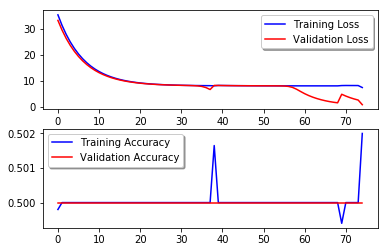

In [12]:
fig, ax = plt.subplots(2,1)
# Loss Plot
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')

legend = ax[0].legend(loc='best', shadow=True)

# Accuracy Plot
ax[1].plot(history.history['acc'], color='b', label='Training Accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation Accuracy')
legend = ax[1].legend(loc='best', shadow=True)

# Fitting the test data

In [13]:
print("Loading Test Images...")
test_data, _ = load_image_list(test_image_list, False)
test_data = test_data / 255.0

print ("Test data shape: {}".format(test_data.shape))

Loading Test Images...


12500it [00:40, 308.46it/s]


Test data shape: (12500, 128, 128, 3)


In [14]:
test_predictions = model.predict(test_data, verbose=1)

12500/12500 [==============================] - ETA: 3: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 56 - ETA: 53 - ETA: 50 - ETA: 48 - ETA: 46 - ETA: 45 - ETA: 44 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ET

In [15]:
print ("Test prediction shape: {}".format(test_predictions.shape))
with open('submission_file.csv','w') as f:
    f.write('id,label\n')

print("Saving the prediction results...")
with open('submission_file.csv','a') as f:
    for i, prediction in tqdm(enumerate(test_predictions)):
        f.write('{},{}\n'.format(i+1,prediction[0]))

Test prediction shape: (12500, 1)
Saving the prediction results...


12500it [00:00, 193147.05it/s]
